#Setting up PySpark in Colab

In [ ]:
!apt-get install openjdk-8-jdk-headless

In [ ]:
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz

--2023-05-19 08:23:53--  https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272637746 (260M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop2.7.tgz’

spark-3.2.1-bin-had 100%[===================>] 260.01M  19.5MB/s    in 14s     

2023-05-19 08:24:08 (18.3 MB/s) - ‘spark-3.2.1-bin-hadoop2.7.tgz’ saved [272637746/272637746]



In [ ]:
!tar xf /content/spark-3.2.1-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.1-bin-hadoop2.7'

In [ ]:
import pyspark
import numpy as np
import pandas as pd

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Big_Data_Assessment")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

#printing spark variable

spark

## Data Preparartion

In [ ]:
combined_data_df = spark.read.csv("/content/combined-data.csv", header=True, inferSchema=True)
combined_data_df.show(5)

+------+-------------+---------+------------+----------------+----------+-----------+---------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
|   812|         5648|        1|     android|              69|         8|       NULL|     NULL|
|  1658|         5649|        1|      iphone|              31|         5|       NULL|     NULL|
|  1589|         5650|        1|      iphone|              26|         2|       NULL|     NULL|
|  1863|         5651|        1|     android|              35|         4|       NULL|     NULL|
|   937|         5652|        1|     android|              39|         0|          1|     1.00|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
only showing top 5 rows



In [ ]:
combined_data_df.count()

4619

In [ ]:
combined_data_df.na.drop().count()

4619

In [ ]:
from pyspark.sql.functions import col, when, sum

combined_data_df = combined_data_df.filter(col("avg_price") != "NULL")

#Creating a new column Spender or Non spender based on avg price
#updated_df = combined_data_df.withColumn("avg_price", when(col("avg_price").isNull(), 0)
 #                                          .when(col("avg_price") > 5.0, 1)
  #                                         .otherwise(0))

updated_df = combined_data_df.withColumn("avg_price", 
                                           when(col("avg_price") > 5.0, 1)
                                           .otherwise(0))
updated_df = updated_df.withColumnRenamed('avg_price', 'Spender_NonSpender')
#updated_df.show(5)

# Count the occurrences of 1 in the transformed column
ones = updated_df.filter(col("avg_price") == 1).count()
print("1:",ones)
zeros = updated_df.filter(col("avg_price") == 0).count()
print("0:", zeros)

updated_df.show(5)

#updated_df = updated_df.select('teamLevel','platformType', 'count_gameclicks', 'count_hits', 'count_buyId',
                    #                   'Spender_NonSpender')  

#updated_df.show(5)

1: 575
0: 836
+------+-------------+---------+------------+----------------+----------+-----------+------------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|Spender_NonSpender|
+------+-------------+---------+------------+----------------+----------+-----------+------------------+
|   937|         5652|        1|     android|              39|         0|          1|                 0|
|  1623|         5659|        1|      iphone|             129|         9|          1|                 1|
|    83|         5661|        1|     android|             102|        14|          1|                 0|
|   121|         5665|        1|     android|              39|         4|          1|                 0|
|   462|         5666|        1|     android|              90|        10|          1|                 0|
+------+-------------+---------+------------+----------------+----------+-----------+------------------+
only showing top 5 rows



In [ ]:
import pyspark.sql.functions as f

transformed_df = updated_df.groupby("userId") \
    .agg(f.sum("count_gameclicks").alias('total_gameclicks'),
         f.sum("count_hits").alias("total_hits"))
    
# Join dfs
ml_df = updated_df.join(transformed_df, "userId", "inner")
ml_df.show(3)

+------+-------------+---------+------------+----------------+----------+-----------+------------------+----------------+----------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|Spender_NonSpender|total_gameclicks|total_hits|
+------+-------------+---------+------------+----------------+----------+-----------+------------------+----------------+----------+
|   937|         5652|        1|     android|              39|         0|          1|                 0|              39|         0|
|  1623|         5659|        1|      iphone|             129|         9|          1|                 1|             406|        48|
|    83|         5661|        1|     android|             102|        14|          1|                 0|             591|        70|
+------+-------------+---------+------------+----------------+----------+-----------+------------------+----------------+----------+
only showing top 3 rows



## Convert Categorical column to numeric

In [ ]:
from pyspark.ml.feature import StringIndexer

# Create an indexer
indexer = StringIndexer(inputCol='platformType', outputCol='platformType_idx')

# Indexer identifies categories in the data
indexer_model = indexer.fit(ml_df)

# Indexer creates a new column with numeric index values
indexed_ml_df = indexer_model.transform(ml_df)

indexed_ml_df.show(3)

classifier_df = indexed_ml_df.select('teamLevel','platformType_idx', 'total_hits','Spender_NonSpender') 
classifier_df.show(3)

+------+-------------+---------+------------+----------------+----------+-----------+------------------+----------------+----------+----------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|Spender_NonSpender|total_gameclicks|total_hits|platformType_idx|
+------+-------------+---------+------------+----------------+----------+-----------+------------------+----------------+----------+----------------+
|   937|         5652|        1|     android|              39|         0|          1|                 0|              39|         0|             1.0|
|  1623|         5659|        1|      iphone|             129|         9|          1|                 1|             406|        48|             0.0|
|    83|         5661|        1|     android|             102|        14|          1|                 0|             591|        70|             1.0|
+------+-------------+---------+------------+----------------+----------+-----------+---------------

## Vectorization and Train-test split

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Create an assembler object
assembler = VectorAssembler(inputCols=['total_hits',
 'teamLevel',
'platformType_idx'
], outputCol='features')

# Consolidate predictor columns
classifier_assembled = assembler.transform(classifier_df)

In [ ]:
# Split into training and test sets in a 80:20 ratio
train_set, test_set = classifier_assembled.randomSplit([0.7, 0.3], seed=17)

# Check that training set has around 80% of records
training_ratio = train_set.count() / classifier_assembled.count()
print(training_ratio)

0.6931254429482636


# Decision Tree

## Build a Decision Tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

# Create a classifier object and fit to the training data
tree = DecisionTreeClassifier(labelCol='Spender_NonSpender')
tree_model = tree.fit(train_set)

# Create predictions for the testing data and take a look at the predictions
prediction = tree_model.transform(test_set)
prediction.select('Spender_NonSpender', 'prediction', 'probability').show(5, False)

+------------------+----------+----------------------------------------+
|Spender_NonSpender|prediction|probability                             |
+------------------+----------+----------------------------------------+
|1                 |1.0       |[0.16521739130434782,0.8347826086956521]|
|1                 |1.0       |[0.16521739130434782,0.8347826086956521]|
|1                 |1.0       |[0.16521739130434782,0.8347826086956521]|
|1                 |1.0       |[0.16521739130434782,0.8347826086956521]|
|1                 |1.0       |[0.16521739130434782,0.8347826086956521]|
+------------------+----------+----------------------------------------+
only showing top 5 rows



## Decision Tree Evaluation

In [ ]:
# Create a confusion matrix
prediction.groupBy('Spender_NonSpender', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND Spender_NonSpender = prediction').count()
TP = prediction.filter('prediction = 1 AND Spender_NonSpender = prediction').count()
FN = prediction.filter('prediction = 1 AND Spender_NonSpender = 0').count()
FP = prediction.filter('prediction = 0 AND Spender_NonSpender= 1').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN + TP) / (TN + TP + FN + FP)
print(accuracy)

+------------------+----------+-----+
|Spender_NonSpender|prediction|count|
+------------------+----------+-----+
|                 1|       0.0|   36|
|                 0|       0.0|  234|
|                 1|       1.0|  139|
|                 0|       1.0|   24|
+------------------+----------+-----+

0.8614318706697459


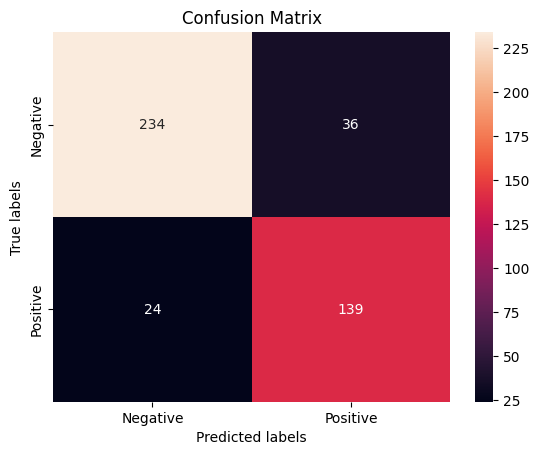

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define the confusion matrix values
conf_matrix = np.array([[TN, FP], [FN, TP]])

# Set the labels for the confusion matrix
labels = ['Non-Spender', 'Spender']

sns.heatmap(conf_matrix, annot=True, fmt='g')
# Add labels, title, and axis ticks
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'])
plt.show()

# Logistic Regression

## Build LR model

In [ ]:
from pyspark.ml.classification import LogisticRegression

# Create classifier object and train on training data
logistic = LogisticRegression(labelCol='Spender_NonSpender').fit(train_set)

# Create a predictions for the test data and show confusion matrix
prediction = logistic.transform(test_set)
prediction.groupBy("Spender_NonSpender", "prediction").count().show()

+------------------+----------+-----+
|Spender_NonSpender|prediction|count|
+------------------+----------+-----+
|                 1|       0.0|   34|
|                 0|       0.0|  233|
|                 1|       1.0|  141|
|                 0|       1.0|   25|
+------------------+----------+-----+



## Evaluating LR model

In [ ]:
# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND Spender_NonSpender = prediction').count()
TP = prediction.filter('prediction = 1 AND Spender_NonSpender = prediction').count()
FN = prediction.filter('prediction = 1 AND Spender_NonSpender = 0').count()
FP = prediction.filter('prediction = 0 AND Spender_NonSpender= 1').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN + TP) / (TN + TP + FN + FP)
print(accuracy)

0.8637413394919169


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Calculate precision and recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print('precision = {:.2f}\nrecall   = {:.2f}'.format(precision, recall))

# Find weighted precision
multi_evaluator = MulticlassClassificationEvaluator().setLabelCol("Spender_NonSpender")
weighted_precision = multi_evaluator.evaluate(prediction, {multi_evaluator.metricName: "weightedPrecision"})

# Find AUC
binary_evaluator = BinaryClassificationEvaluator().setLabelCol("Spender_NonSpender")
auc = binary_evaluator.evaluate(prediction, {binary_evaluator.metricName: "areaUnderROC"})

print(auc)
print(weighted_precision)

precision = 0.81
recall   = 0.85
0.8707419712070883
0.8632578423302156


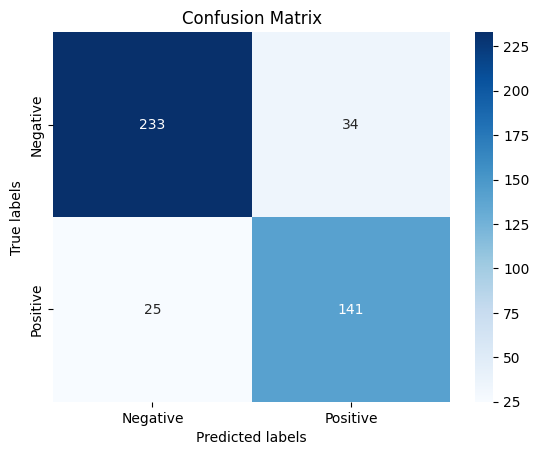

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define the confusion matrix values
conf_matrix = np.array([[TN, FP], [FN, TP]])

# Set the labels for the confusion matrix
labels = ['Non-Spender', 'Spender']

sns.heatmap(conf_matrix, annot=True, fmt='g',cmap='Blues')
# Add labels, title, and axis ticks
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'])
plt.show()

# Clustering

## Data Preparation

In [ ]:
indexed_ml_df.show(3)

+------+-------------+---------+------------+----------------+----------+-----------+------------------+----------------+----------+----------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|Spender_NonSpender|total_gameclicks|total_hits|platformType_idx|
+------+-------------+---------+------------+----------------+----------+-----------+------------------+----------------+----------+----------------+
|   937|         5652|        1|     android|              39|         0|          1|                 0|              39|         0|             1.0|
|  1623|         5659|        1|      iphone|             129|         9|          1|                 1|             406|        48|             0.0|
|    83|         5661|        1|     android|             102|        14|          1|                 0|             591|        70|             1.0|
+------+-------------+---------+------------+----------------+----------+-----------+---------------

In [ ]:
combined_data_df.show(3)

+------+-------------+---------+------------+----------------+----------+-----------+---------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
|   937|         5652|        1|     android|              39|         0|          1|     1.00|
|  1623|         5659|        1|      iphone|             129|         9|          1|    10.00|
|    83|         5661|        1|     android|             102|        14|          1|     5.00|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
only showing top 3 rows



In [ ]:
import pyspark.sql.functions as f
from pyspark.sql import Window
from pyspark.sql.functions import rank,sum,col

window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)

# Indexing
indexer = StringIndexer(inputCol='platformType', outputCol='platformType_indexed')
# Indexer identifies categories in the data
indexer_model = indexer.fit(combined_data_df)
# Indexer creates a new column with numeric index values
indexed_ml_df = indexer_model.transform(combined_data_df)

indexed_ml_df = indexed_ml_df.withColumn("avg_price", when(col("avg_price") == "NULL", 0).otherwise(col("avg_price")))

indexed_ml_df = indexed_ml_df\
                          .withColumn('total',sum(f.col('avg_price')).over(window))\
                          .withColumn("Spender_NonSpender", f.when(f.col("avg_price") > 5,1).otherwise(0))

indexed_ml_df.show(3)

# Group by userId and calculate total_gameclicks and total_hits
cluster_df = indexed_ml_df.groupby("userId") \
    .agg(f.sum("count_gameclicks").alias('total_gameclicks'),
         f.sum("count_hits").alias("total_hits"),
         f.sum("avg_price").alias("avg_price_total"))\
    .withColumn('Percent', f.col('total_hits') * 100 / f.col('total_gameclicks')) \
    .withColumn("Hitter_NonHitter", f.when(f.col("Percent") > 10, 1).otherwise(0))

cluster_df.show(3)

k_mean_df = cluster_df.join(indexed_ml_df, "userId", "inner")

k_mean_df.show(3)


+------+-------------+---------+------------+----------------+----------+-----------+---------+--------------------+------------------+------------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|platformType_indexed|             total|Spender_NonSpender|
+------+-------------+---------+------------+----------------+----------+-----------+---------+--------------------+------------------+------------------+
|   937|         5652|        1|     android|              39|         0|          1|     1.00|                 1.0|10179.410000000002|                 0|
|  1623|         5659|        1|      iphone|             129|         9|          1|    10.00|                 0.0|10179.410000000002|                 1|
|    83|         5661|        1|     android|             102|        14|          1|     5.00|                 1.0|10179.410000000002|                 0|
+------+-------------+---------+------------+----------------+--------

# K Means Clustering

## Build Model

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

featuresUsed = [
 'teamLevel',
"avg_price_total",
"total_hits",
"platformType_indexed",
"Hitter_NonHitter",
"Spender_NonSpender",
 ]

# set up each processing step with the correct input columns and output
assemble=VectorAssembler(inputCols=featuresUsed, outputCol='features')
scale=StandardScaler(inputCol='features',outputCol='standardized')
km = KMeans(featuresCol = 'standardized')

# assemble the pipeline 
pipe = Pipeline(stages=[assemble, scale, km])

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# set up evaluator 
evaluator = ClusteringEvaluator()

# test between k=2 and 10 
for k in range(2,10):
  # set the KMeans stage of the pipe to hold each value of K and the random seed = 1 and fit that pipe to data  
  kmeans = pipe.getStages()[-1].setK(k).setSeed(1)  
  model = pipe.fit(k_mean_df)
  
  # build a preds dataset of each k value
  preds = model.transform(k_mean_df)

  # silhouette score each prediction set and print formatted output 
  silhouette = evaluator.evaluate(preds)
  print(f'Tested: {k} clusters: {silhouette}')

Tested: 2 clusters: 0.27221317514495813
Tested: 3 clusters: -0.07950215452572486
Tested: 4 clusters: 0.1534917054911464
Tested: 5 clusters: 0.009992816199958478
Tested: 6 clusters: 0.0014553314460429361
Tested: 7 clusters: 0.02473375473034433
Tested: 8 clusters: -0.06878638951521969
Tested: 9 clusters: -0.06662122749908732


The highest scoring value for K was 2. However there is a tradeoff to be considered here as 2 clusters would not tell us much about the underlying structure of the data, alternatively the silhouette score at k=4 is also very high. Three clusters should separate our data in a more meaningful way.

In [ ]:
pipe.getStages()[-1].setK(4).setSeed(1)  # set the random seed for the algorithm and the value for k

# fit model and transform the data
model = pipe.fit(k_mean_df)
clusters = model.transform(k_mean_df)
clusters.show()

+------+----------------+----------+---------------+------------------+----------------+-------------+---------+------------+----------------+----------+-----------+---------+--------------------+------------------+------------------+--------------------+--------------------+----------+
|userId|total_gameclicks|total_hits|avg_price_total|           Percent|Hitter_NonHitter|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|platformType_indexed|             total|Spender_NonSpender|            features|        standardized|prediction|
+------+----------------+----------+---------------+------------------+----------------+-------------+---------+------------+----------------+----------+-----------+---------+--------------------+------------------+------------------+--------------------+--------------------+----------+
|   937|              39|         0|            1.0|               0.0|               0|         5652|        1|     android|           

In [ ]:
# Print cluster centers
kmeans_model = model.stages[-1]
cluster_centers = kmeans_model.clusterCenters()
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i}: {center}")


    'teamLevel',
"avg_price_total",
"total_hits",
"platformType_indexed",
"Hitter_NonHitter",
"Spender_NonSpender",

Cluster 0: [2.69221066 0.52738379 1.07493231 1.51191111 2.66953475 0.05059769]
Cluster 1: [2.82694309 0.4789373  0.82165603 1.23303438 0.         0.40313729]
Cluster 2: [2.20342688 0.98701034 3.92231241 1.12566665 2.55244989 0.5910989 ]
Cluster 3: [2.75856681 2.03427329 1.24957437 0.10939165 2.66953475 1.9192138 ]


## Visualisation

In [ ]:
import plotly.express as px


vis_df = clusters.toPandas()
#vis_df

# build figure with 3D numeric dimensions and categorical isPlanet and prediction dimensions
fig = px.scatter_3d(vis_df, x='avg_price_total', y="total_hits", z='teamLevel', color='prediction',size_max=0.05)
fig.show()


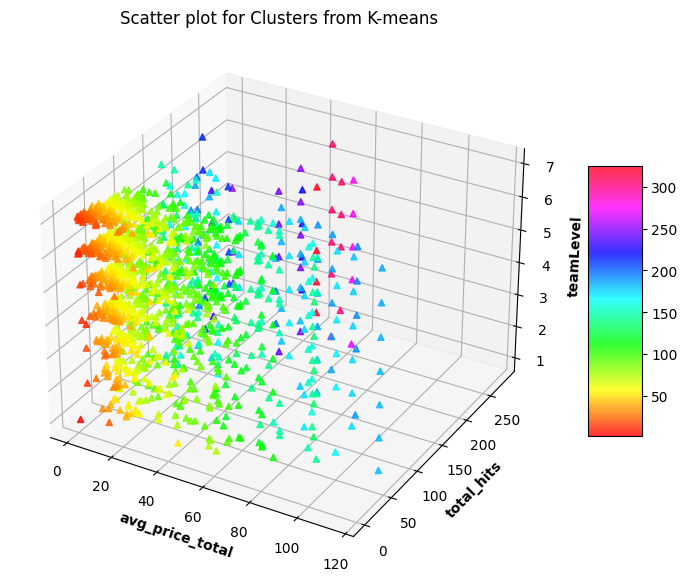

In [ ]:
# Import libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
vis_df = clusters.toPandas()
# Creating dataset
z = np.array(vis_df['teamLevel'])
x = np.array(vis_df['avg_price_total'])
y = np.array(vis_df['total_hits'])

colours = ['red','green','yellow','blue']
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)

# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = (x + y + z),
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("Scatter plot for Clusters from K-means")
ax.set_xlabel('avg_price_total', fontweight ='bold')
ax.set_ylabel('total_hits', fontweight ='bold')
ax.set_zlabel('teamLevel', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()

# Hierarchial Clustering

In [ ]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

assembled_data = assemble.transform(k_mean_df) 

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette')
for K in range(2,11):

    BKMeans_=BisectingKMeans(featuresCol='features', k=K, minDivisibleClusterSize =1)

    BKMeans_fit=BKMeans_.fit(assembled_data)

    BKMeans_transform=BKMeans_fit.transform(assembled_data) 

    evaluation_score=evaluator.evaluate(BKMeans_transform)

    silhouette_scores.append(evaluation_score)





Plot the silhouette scores against the number of clusters.

Text(0, 0.5, 'Silhouette Score')

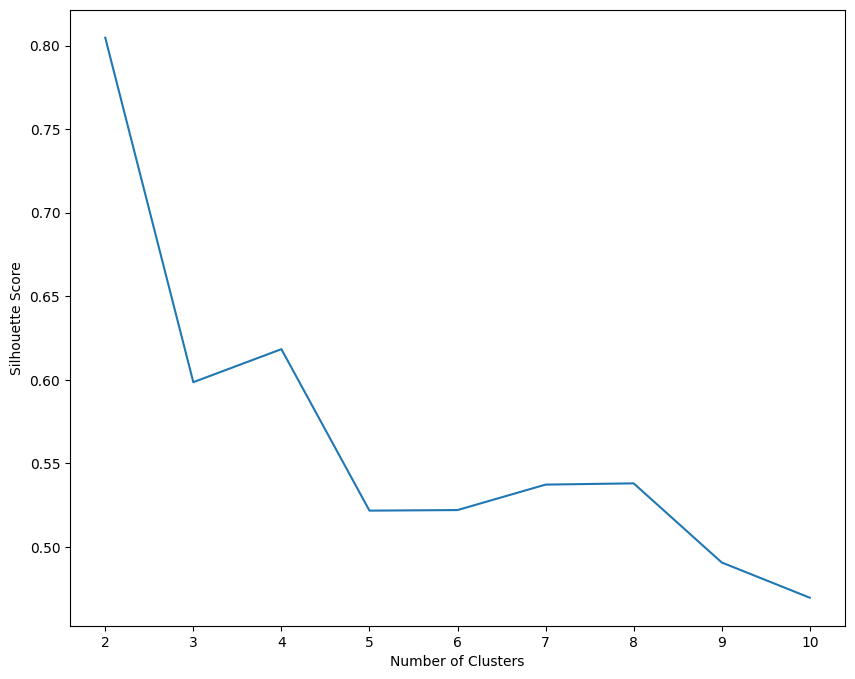

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

## Building Hierarchical model 

In [ ]:
BKMeans_=BisectingKMeans(featuresCol='features', k=4) 
BKMeans_Model=BKMeans_.fit(assembled_data)
BKMeans_transform=BKMeans_Model.transform(assembled_data)

## Visualize Hierarchical Clustering using the PCA

To visualize the 4-dimensional data into 2, we will use a dimensionality reduction technique viz. PCA. Spark has its own flavour of PCA.

In [ ]:
#perform the PCA
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(assembled_data)
pca_transformed = pca_model.transform(assembled_data)

In [ ]:
#extract the principal components
import numpy as np
X_pca = pca_transformed.rdd.map(lambda row: row.pca).collect()
X_pca = np.array(X_pca)

In [ ]:
#retrieve the cluster assignments from bisecting k-means assignments
cluster_assignment = np.array(BKMeans_transform.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)
cluster_assignment

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

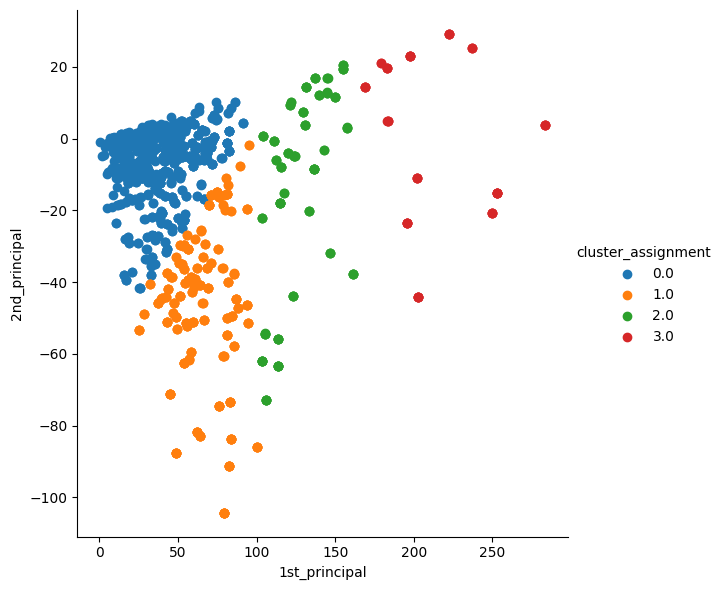

In [ ]:
#plot the principal components

import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((X_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()
plt.show()